# Practise Segmentation

## Dataset

We'll use the Oxford-IIIT Pet Dataset. It consists of 37 classes of dogs and cats, with about 200 images per class. The dataset contains both boxes and masks. There are approximately 7,000 images in the dataset.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Let's download and unpack data.

In [315]:
# %%capture out
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

Note that we have two folders in the data. The first contains `images`, and the second contains masked images marked as `binary`.

## Import Libraries

Import libraries and define constants.

In [316]:
import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split

is_debug_mode = False

num_epochs = 5 if is_debug_mode else 20

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

path_images = "data/images/"
path_masks = "data/annotations/trimaps/"

Using device: mps


## Data Preparation

Define transformations for traning and validation; and augmentations for training.

In [317]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(256, 256)
], additional_targets={'mask': 'mask'})

/Users/dmitriygolubitskiy/Library/Mobile Documents/com~apple~CloudDocs/Documents/Technology/Data Science/IDE2/DataCleaningProject/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Each pixel in the mask image can take one of three values: "1," "2," or "3." "1" means that the pixel belongs to the "animal" class, "2" to the "background" class, and "3" to the "border" class. Since this example demonstrates a binary segmentation task (that is, assigning one of two classes to each pixel), we'll preprocess the mask so it contains only two unique values: 0 if the pixel is background, and 1 if the pixel is an animal or a border.

In [318]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [319]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, split="train"):
        images_train, images_val = train_test_split(
            os.listdir(image_dir), random_state=142, shuffle=True, train_size=0.8
        )
        if split == "train":
            self.images = images_train
        else:
            self.images = images_val

        self.transform = transform

        self.image_dir = image_dir
        self.mask_dir = mask_dir

        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]

        image = Image.open(os.path.join(self.image_dir, name)).convert("RGB")
        mask  = Image.open(os.path.join(self.mask_dir, name.replace(".jpg", ".png"))).convert("L")

        image_np = np.array(image)
        mask_np  = np.array(mask)

        mask_np = preprocess_mask(mask_np)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented["image"]
            mask  = augmented["mask"]

        # To Tensor
        image = TF.to_tensor(image)
        image = self.normalize(image)

        mask = TF.to_tensor(mask).squeeze(0)
        mask = (mask > 0.5).long()  # binarize

        return image, mask


Loading datasets and defining data loaders.

For development and debugging I use Subsets of data to get results faster.

In [320]:
dataset_train = SegmentationDataset(
    path_images, 
    path_masks, 
    transform=train_transform,
    split="train"
)
if is_debug_mode:
    dataset_train = torch.utils.data.Subset(dataset_train, range(400))

dataset_val = SegmentationDataset(
    path_images, 
    path_masks, 
    transform=val_transform,
    split="val"
)
if is_debug_mode:
    dataset_val = torch.utils.data.Subset(dataset_val, range(100))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
val_loader   = DataLoader(dataset_val, batch_size=4, shuffle=False)

### Visualization of Segments

Training dataset


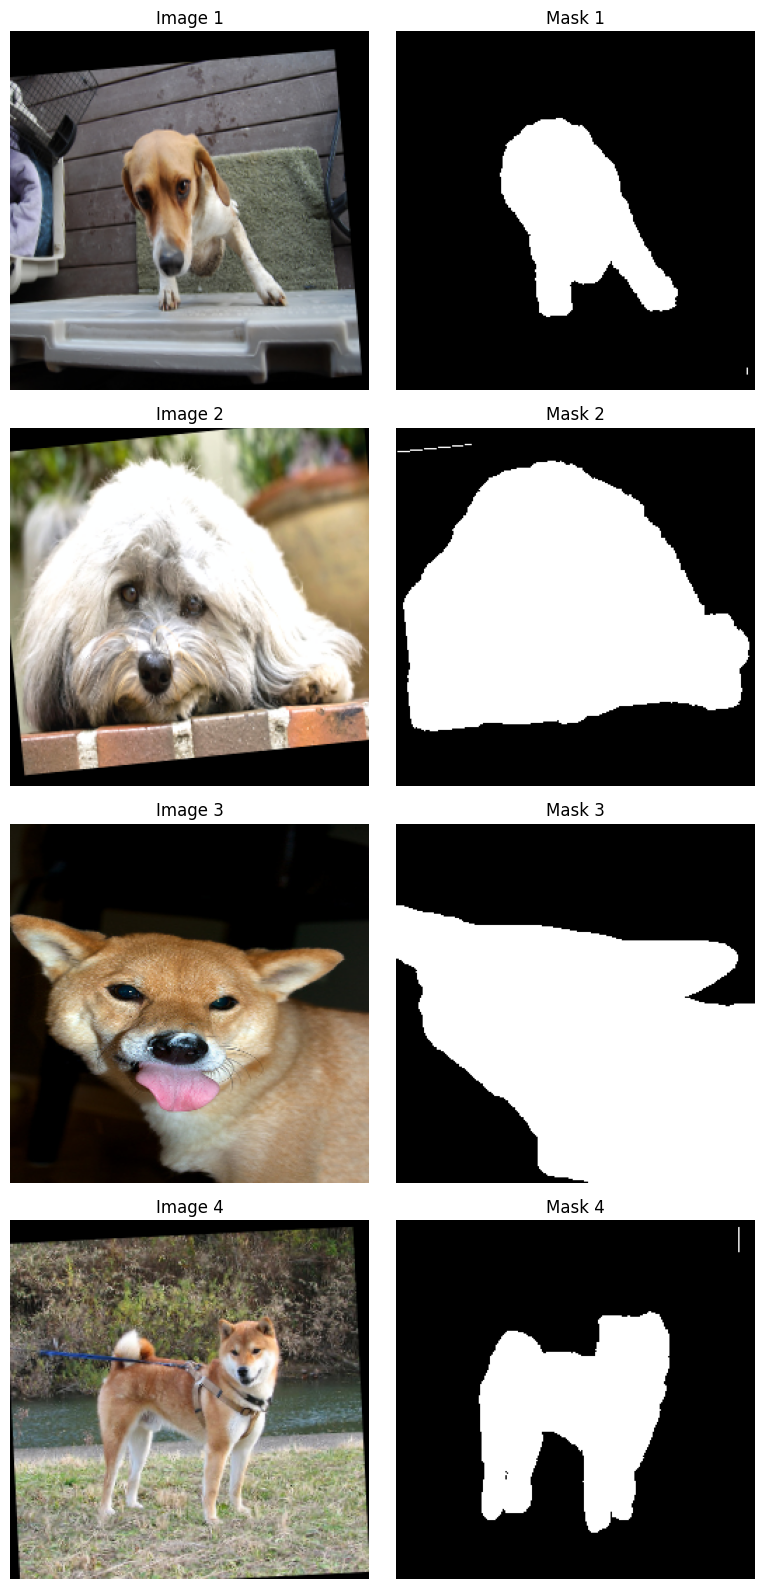

Validation dataset


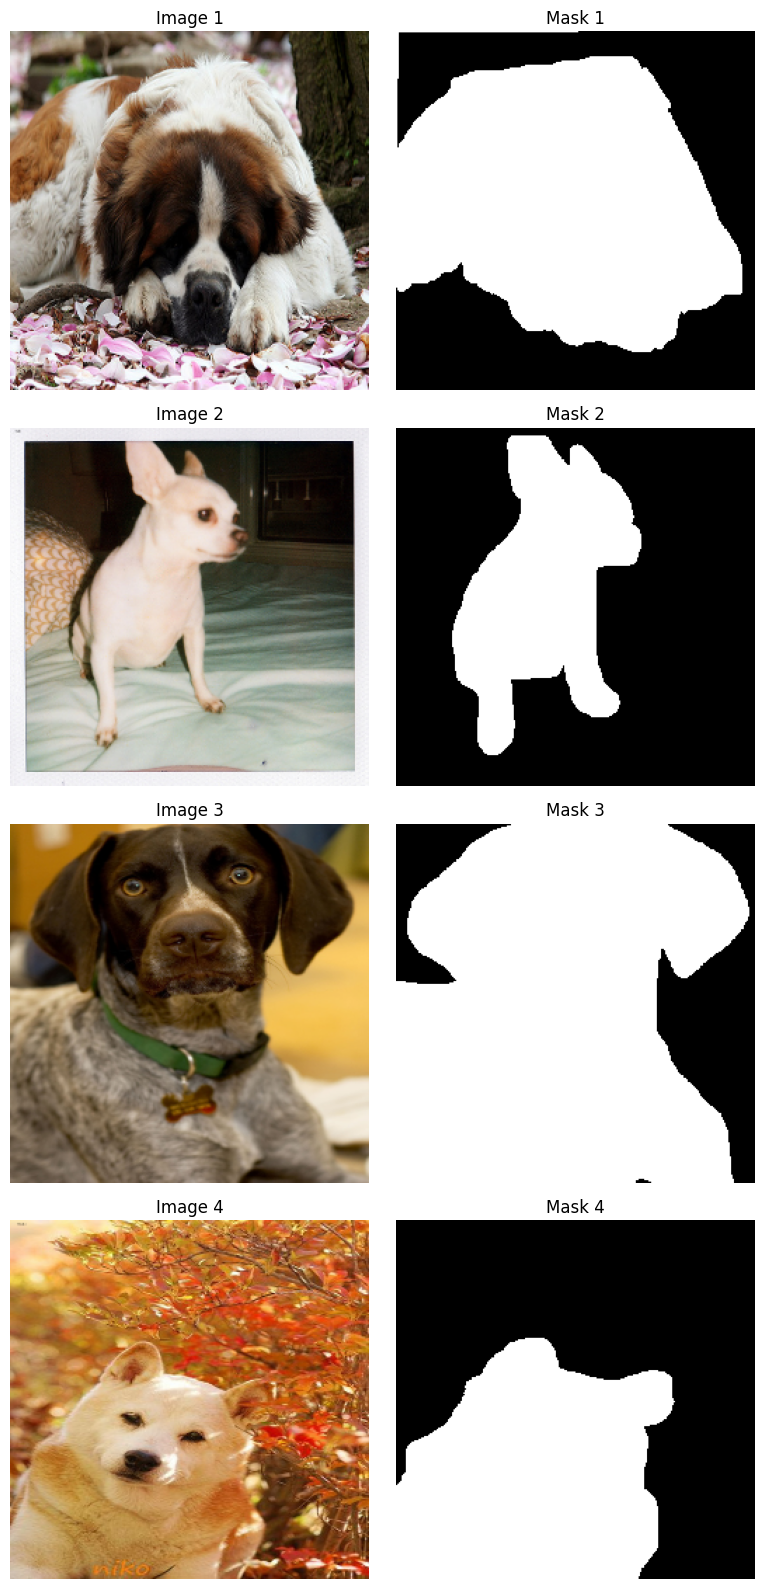

In [321]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))

    for i in range(num_samples):
        image, mask = dataset[i]
        
        # image is a tensor [C,H,W] normalized; denormalize for display
        image_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = (image_np * std + mean).clip(0, 1)
        
        # mask is already [H,W] long tensor
        mask_np = mask.numpy()
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

print("Training dataset")
plot_samples(dataset_train)
print("Validation dataset")
plot_samples(dataset_val)


## Defining the Model

DeepLabV3-ResNet50 has been chosen: it is suitable for this segmentation task because it provides strong performance through multi-scale feature extraction using atrous convolutions and ASPP. The ResNet-50 backbone offers a good balance between accuracy and computational efficiency, enabling effective training even on moderately sized datasets. Overall, the model delivers reliable segmentation quality while maintaining reasonable training and inference speed.

In [322]:
model = deeplabv3_resnet50(weights=None, num_classes=2)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Defining the loss function and the optimizer.

In [323]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

IoU metric calculatio.

In [324]:
def iou_score(pred, target):
    pred = torch.argmax(pred, dim=1)  # [B,H,W]
    
    intersection = ((pred == 1) & (target == 1)).sum().float()
    union        = ((pred == 1) | (target == 1)).sum().float()
    
    if union == 0:
        return torch.tensor(1.0)  # empty mask case
    
    return intersection / union


## Training and Validation

In [325]:
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_iou  = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou  += iou_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou  /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_iou  = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou  += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")


100%|██████████| 370/370 [00:49<00:00,  7.48it/s]


Epoch 1/20 | Train Loss: 0.1574 | Train IoU: 0.8649 | Val Loss: 0.1340 | Val IoU: 0.8887


100%|██████████| 370/370 [00:46<00:00,  7.88it/s]


Epoch 2/20 | Train Loss: 0.1242 | Train IoU: 0.8896 | Val Loss: 0.1123 | Val IoU: 0.9055


100%|██████████| 370/370 [00:47<00:00,  7.86it/s]


Epoch 3/20 | Train Loss: 0.1165 | Train IoU: 0.8965 | Val Loss: 0.1094 | Val IoU: 0.9075


100%|██████████| 370/370 [00:47<00:00,  7.86it/s]


Epoch 4/20 | Train Loss: 0.1091 | Train IoU: 0.9027 | Val Loss: 0.1108 | Val IoU: 0.9065


100%|██████████| 370/370 [00:46<00:00,  8.01it/s]


Epoch 5/20 | Train Loss: 0.1037 | Train IoU: 0.9070 | Val Loss: 0.1120 | Val IoU: 0.9052


100%|██████████| 370/370 [00:46<00:00,  7.94it/s]


Epoch 6/20 | Train Loss: 0.1009 | Train IoU: 0.9085 | Val Loss: 0.1091 | Val IoU: 0.9108


100%|██████████| 370/370 [00:47<00:00,  7.79it/s]


Epoch 7/20 | Train Loss: 0.0993 | Train IoU: 0.9102 | Val Loss: 0.1132 | Val IoU: 0.9038


100%|██████████| 370/370 [00:46<00:00,  7.99it/s]


Epoch 8/20 | Train Loss: 0.0921 | Train IoU: 0.9153 | Val Loss: 0.1052 | Val IoU: 0.9124


100%|██████████| 370/370 [00:45<00:00,  8.05it/s]


Epoch 9/20 | Train Loss: 0.0876 | Train IoU: 0.9186 | Val Loss: 0.1061 | Val IoU: 0.9112


100%|██████████| 370/370 [00:46<00:00,  8.03it/s]


Epoch 10/20 | Train Loss: 0.0863 | Train IoU: 0.9193 | Val Loss: 0.1022 | Val IoU: 0.9146


100%|██████████| 370/370 [00:46<00:00,  7.97it/s]


Epoch 11/20 | Train Loss: 0.0846 | Train IoU: 0.9209 | Val Loss: 0.1069 | Val IoU: 0.9130


100%|██████████| 370/370 [00:46<00:00,  7.95it/s]


Epoch 12/20 | Train Loss: 0.0834 | Train IoU: 0.9215 | Val Loss: 0.1090 | Val IoU: 0.9115


100%|██████████| 370/370 [00:46<00:00,  8.02it/s]


Epoch 13/20 | Train Loss: 0.0805 | Train IoU: 0.9234 | Val Loss: 0.1067 | Val IoU: 0.9118


100%|██████████| 370/370 [00:47<00:00,  7.81it/s]


Epoch 14/20 | Train Loss: 0.0803 | Train IoU: 0.9240 | Val Loss: 0.1130 | Val IoU: 0.9090


100%|██████████| 370/370 [00:46<00:00,  7.95it/s]


Epoch 15/20 | Train Loss: 0.0776 | Train IoU: 0.9257 | Val Loss: 0.1024 | Val IoU: 0.9174


100%|██████████| 370/370 [00:48<00:00,  7.68it/s]


Epoch 16/20 | Train Loss: 0.0746 | Train IoU: 0.9280 | Val Loss: 0.1069 | Val IoU: 0.9165


100%|██████████| 370/370 [00:46<00:00,  7.98it/s]


Epoch 17/20 | Train Loss: 0.0743 | Train IoU: 0.9284 | Val Loss: 0.1082 | Val IoU: 0.9104


100%|██████████| 370/370 [00:46<00:00,  7.98it/s]


Epoch 18/20 | Train Loss: 0.0745 | Train IoU: 0.9281 | Val Loss: 0.1088 | Val IoU: 0.9160


100%|██████████| 370/370 [00:45<00:00,  8.05it/s]


Epoch 19/20 | Train Loss: 0.0745 | Train IoU: 0.9283 | Val Loss: 0.1188 | Val IoU: 0.9083


100%|██████████| 370/370 [00:46<00:00,  8.00it/s]

Epoch 20/20 | Train Loss: 0.0716 | Train IoU: 0.9300 | Val Loss: 0.1057 | Val IoU: 0.9180


## Conclusion

After 20 training epochs the model has reached some level of saturation with the max IoU = 0.918.